Plot dendrograms 

determine best model automatically using cophenetic coefficient

determine number of clusters with fcluster and max inconsistency

test of elbow method (unconclusive)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os, glob, inspect, sys

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib as mc
from importlib import reload
reload(mc)

# Import data

In [ ]:
data_path = "../../Data/Merged_data"
df = pd.read_csv(os.path.join(data_path, 'ALL_TUBE_PIPE_merge_1.csv'), 
                 index_col=0)


## Calculating new values

In [ ]:
calc_df = mc.updated_df(df, mc.measures_list, mc.errors_list)

## Scaling values

In [ ]:
scaled_df = mc.scale_general(calc_df, MinMaxScaler())[0]


## Selecting sub samples

In [ ]:
tube, pipe, tube_wo_blind, tube_blind = mc.get_subsample_df(calc_df)

In [ ]:
tube_scaled, pipe_scaled, tube_wo_blind_scaled, tube_blind_scaled = mc.get_subsample_df(scaled_df)

In [ ]:
corr_scaled_df = scaled_df.copy().loc[:,mc.correlation_list]
tube_scaled_corr, pipe_scaled_corr, \
tube_wo_blind_scaled_corr, tube_blind_scaled_corr = mc.get_subsample_df(corr_scaled_df)

In [ ]:
mini_scaled_df = scaled_df.copy().loc[:,mc.minimal_informative_features]
tube_scaled_mini, pipe_scaled_mini, \
tube_wo_blind_scaled_mini, tube_blind_scaled_mini = mc.get_subsample_df(mini_scaled_df)

# Cophenetic Correlation Coefficient 
Calculate the cophenetic distances between each observation in the hierarchical clustering defined by the linkage Z.

Suppose that the original data {Xi} have been modeled using a cluster method to produce a dendrogram {Ti}; that is, a simplified model in which data that are "close" have been grouped into a hierarchical tree. Define the following distance measures.
- x(i, j) = | Xi − Xj |, the ordinary Euclidean distance between the ith and jth observations.
- t(i, j) = the dendrogrammatic distance between the model points Ti and Tj. This distance is the height of the node at which these two points are first joined together.

Then, letting x ¯ {\displaystyle {\bar {x}}} {\bar {x}} be the average of the x(i, j), and letting t ¯ {\displaystyle {\bar {t}}} {\bar {t}} be the average of the t(i, j), the cophenetic correlation coefficient c is given by



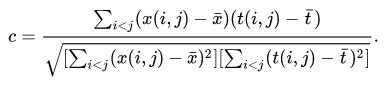

In [ ]:
# The closer the value is to 1, the better the clustering preserves the original distances.
def get_c (df):
    results = []
    for linkage_name in ['single', 'average', 'weighted', 'centroid', 'median', 'ward']:
        for metric_name in ['chebyshev', 'cityblock', 'cosine', 'euclidean', 'minkowski', 'sqeuclidean']:
            try:
                Z = hierarchy.linkage(df, method=linkage_name, metric=metric_name)
            except ValueError:
                pass
            c, coph_dists = hierarchy.cophenet(Z, pdist(df, metric_name))

            results.append([linkage_name, metric_name, c])
    data = pd.DataFrame(results, columns=['linkage', 'distance metric', 'C']).sort_values('C', ascending=False)
    return data

In [ ]:
get_c(tube_scaled_corr)

In [ ]:
get_c(tube_wo_blind_scaled_corr)

In [ ]:
get_c(tube_scaled_mini)

In [ ]:
get_c(tube_wo_blind_scaled_mini)

# Clustering

In [ ]:
sns.clustermap(tube_scaled_mini, method='average', metric='chebyshev', cmap='PuBu', figsize=(6,8), dendrogram_ratio=(0.2, 0.2), cbar_pos=(0.05, 0.85, 0.025, 0.1))

In [ ]:
sns.clustermap(tube_scaled_corr, method='average', metric='euclidean', cmap='PuBu', figsize=(6,8), dendrogram_ratio=(0.2, 0.2), cbar_pos=(0.05, 0.85, 0.025, 0.1))

## Scipy dendrograms

In [ ]:
color = sns.xkcd_palette(['grey', 'medium blue', 'blush pink', 'seafoam blue', 'navy blue', ])
sns.set_theme(style="white")
sns.set_palette(color)

### Tubes with selected features

In [ ]:
#All tubes
Z1 = hierarchy.linkage(tube_scaled_corr,
method='average',
metric='euclidean')

ax, fig = plt.subplots(figsize=(7,9))


dendro = hierarchy.dendrogram(Z1, labels=tube_scaled_corr.index, leaf_rotation=0, orientation='left',
                         color_threshold=0.45)

for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):
    y = 0.5 * sum(i[1:3])
    x = d[1]
    plt.plot(x, y, 'o', c=c)
    plt.annotate('%.3g'%x, (x, y), xytext=(5, -5),
                 textcoords = 'offset points',
                 va='bottom', ha='left',
                 fontsize=10
                )


plt.xlabel('Distance')
plt.title('Known and unknown tubes')
sns.despine(left=True)

In [ ]:
#known tubes
Z1_wo = hierarchy.linkage(tube_wo_blind_scaled_corr,
method='average',
metric='euclidean')

ax, fig = plt.subplots(figsize=(7,9))
dendro = hierarchy.dendrogram(Z1_wo, labels=tube_wo_blind_scaled_corr.index, leaf_rotation=0, orientation='left',
                         color_threshold=0.8)

for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):
    y = 0.5 * sum(i[1:3])
    x = d[1]
    plt.plot(x, y, 'o', c=c)
    plt.annotate('%.3g'%x, (x, y), xytext=(5, -5),
                 textcoords = 'offset points',
                 va='bottom', ha='left',
                 fontsize=10
                )

plt.xlabel('Distance')
plt.title('Known tubes')
sns.despine(left=True)

With arbitrary max distance choose we found 3 clusters reproducible within conditions

### Tubes with minimal number of features

In [ ]:
#All tubes
sns.set_theme(style="white")
sns.set_palette(color)
Z2 = hierarchy.linkage(tube_scaled_mini,
method='average',
metric='chebyshev')

ax, fig = plt.subplots(figsize=(7,9))

dendro = hierarchy.dendrogram(Z2, labels=tube_scaled_mini.index, leaf_rotation=0, orientation='left',
                         color_threshold=0.3)

for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):
    y = 0.5 * sum(i[1:3])
    x = d[1]
    plt.plot(x, y, 'o', c=c)
    plt.annotate('%.3g'%x, (x, y), xytext=(5, -5),
                 textcoords = 'offset points',
                 va='bottom', ha='left',
                 fontsize=10
                )


plt.xlabel('Distance')
plt.title('All tubes')
sns.despine(left=True)


In [ ]:
#known tubes
sns.set_theme(style="white")
sns.set_palette(color)
Z2_wo = hierarchy.linkage(tube_wo_blind_scaled_mini,
method='average',
metric='chebyshev')

ax, fig = plt.subplots(figsize=(7,9))

dendro = hierarchy.dendrogram(Z2_wo, labels=tube_wo_blind_scaled_mini.index, leaf_rotation=0, orientation='left',
                         color_threshold=0.6)

for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):
    y = 0.5 * sum(i[1:3])
    x = d[1]
    plt.plot(x, y, 'o', c=c)
    plt.annotate('%.3g'%x, (x, y), xytext=(5, -5),
                 textcoords = 'offset points',
                 va='bottom', ha='left',
                 fontsize=10
                )


plt.xlabel('Distance')
plt.title('Known tubes')
sns.despine(left=True)


# fcluster
Cluster observation data using a given metric.

Clusters the original observations in the n-by-m data matrix X (n observations in m dimensions), using the euclidean distance metric to calculate distances between original observations, performs hierarchical clustering using the single linkage algorithm, and forms flat clusters using the inconsistency method with t as the cut-off threshold.

# Inconsistency
The relative consistency of each link in a hierarchical cluster tree can be
quantified and expressed as the inconsistency coefficient. This value compares the height of a link in a cluster hierarchy with the average height of links
below it. Links that join distinct clusters have a high inconsistency coefficient;
links that join indistinct clusters have a low inconsistency coefficient.
By default, the inconsistent function compares each link in the cluster hierarchy with adjacent links that
are less than two levels below it in the cluster hierarchy. This is called the depth of the comparison.

Use depth to test how far down to look, as follow:

`depth = x
incons = hierarchy.inconsistent(Z, depth)`

depth is chosen by testing when the inconsistency matrix does not change

In [ ]:
def inconsistency(linkage_matrix, df, method):
    for depth in np.arange(0,8):
        incons = hierarchy.inconsistent(linkage_matrix, depth)
        max_inc = hierarchy.maxinconsts(linkage_matrix, incons)
        for t in np.unique(np.around(max_inc, 2)):
            cluster = hierarchy.fclusterdata(df, t=t, method=method)
            print('depth:', depth, ': ', 't=', t, ' cluster = ', int(cluster.max()))

In [ ]:
inconsistency(Z1, tube_scaled_corr, 'average')

In [ ]:
inconsistency(Z1_wo, tube_wo_blind_scaled_corr, 'average')

In [ ]:
inconsistency(Z2, tube_scaled_mini, 'average')

In [ ]:
inconsistency(Z2_wo, tube_wo_blind_scaled_mini, 'average')

In [ ]:
# plot_elbow
last = Z1[:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)
plt.ylabel('Distance')
plt.xlabel('Sample numbers')
plt.title('All feat all tubes')

In [ ]:
# plot_elbow
last = Z2[:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)
plt.ylabel('Distance')
plt.xlabel('Sample numbers')
plt.title('Min feat all tubes')